In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
root_path = '/content/gdrive/My Drive/Multi_Task_Learning/PangLee/' #Change the root path accordingly

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [4]:
sentiment_emd =  np.load( root_path + 'Dataset/Polarity_data/bert/bert_emb_1k.npy')

In [5]:
for i in range(2,11):
  sentiment_emd = np.concatenate((sentiment_emd, np.load(root_path + 'Dataset/Polarity_data/bert/bert_emb_{}k.npy'.format(i))), axis=0)

In [6]:
subjective_emd =  np.load(root_path + 'Dataset/Subjective_data/bert/bert_emb_1k.npy')

In [7]:
for i in range(2,11):
  subjective_emd = np.concatenate((subjective_emd, np.load(root_path + 'Dataset/Subjective_data/bert/bert_emb_{}k.npy'.format(i))), axis=0)

In [8]:
sentiment = pd.read_csv( root_path + "Dataset/Polarity_data/sentiment_10k.csv")

In [9]:
subjective = pd.read_csv( root_path + "Dataset/Subjective_data/subjectivity.csv")

In [10]:
sentiment_labels = sentiment[["pos", "neg"]]

In [11]:
subjective_labels = subjective[["sub", "obj"]]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
senti_train, senti_test, sentlabel_train, sentlabel_test = train_test_split(sentiment_emd, sentiment_labels, test_size=0.20, random_state=42)

In [14]:
sub_train, sub_test, sublabel_train, sublabel_test = train_test_split(subjective_emd,subjective_labels, test_size=0.20, random_state=42)

In [15]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=fedd2c5ebabdab50d627048634eb259d18a047f89900981b0905865052509be9
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [16]:
import sys
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import io
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import csv
from keras.layers import Input
from keras.layers.merge import Concatenate
import scipy.stats as stats
from keras import backend as K
from keras.layers.core import Lambda
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Input,Dense,GRU,LSTM,Concatenate,Dropout,Activation,Add, Masking, Concatenate, Dot, RepeatVector, Permute, Multiply, Dense
from keras.layers.pooling import AveragePooling1D,MaxPooling1D
from keras.layers.core import Flatten
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.core import Reshape
from keras.backend import shape
from keras.utils import plot_model
from keras.layers.merge import Multiply,Concatenate
from keras.optimizers import RMSprop,Adadelta,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras import backend as K
import keras.layers as L
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Layer
import keras.backend as K
from keras.utils import plot_model
from keras_self_attention import SeqSelfAttention

Neural Tensor Network | [Paper](https://papers.nips.cc/paper/5028-reasoning-with-neural-tensor-networks-for-knowledge-base-completion.pdf)

In [17]:
class NeuralTensorLayer(Layer):

  def __init__(self, output_dim, input_dim=None, **kwargs):
    self.output_dim = output_dim #k
    self.input_dim = input_dim   #d
    if self.input_dim:
      kwargs['input_shape'] = (self.input_dim,)
    super(NeuralTensorLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    mean = 0.0
    std = 1.0
    # W : k*d*d
    k = self.output_dim
    d = self.input_dim
    initial_W_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d,d))
    initial_V_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
    self.W = K.variable(initial_W_values)
    self.V = K.variable(initial_V_values)
    self.b = K.zeros((self.input_dim,))
    self.trainableweights = [self.W, self.V, self.b]

  def call(self, inputs, mask=None):
    if type(inputs) is not list or len(inputs) <= 1:
      raise Exception('BilinearTensorLayer must be called on a list of tensors '
                      '(at least 2). Got: ' + str(inputs))
    e1 = inputs[0]
    e2 = inputs[1]
    batch_size = K.shape(e1)[0]
    k = self.output_dim

    feed_forward_product = K.dot(K.concatenate([e1,e2], axis=1), self.V)
    bilinear_tensor_products = []
    for i in range(k):
      btp = K.sum((e2 * K.dot(e1, self.W[i])) + self.b, axis=1)
      bilinear_tensor_products.append(btp)
    result = K.tanh(K.reshape(K.concatenate(bilinear_tensor_products, axis=0), (batch_size, k)) + feed_forward_product)
    return result

  def compute_output_shape(self, input_shape):
    batch_size = input_shape[0][0]
    return (batch_size, self.output_dim)


In [18]:
import keras
from keras_self_attention import SeqSelfAttention

# https://github.com/CyberZHG/keras-self-attention

In [19]:
###Multi task Model
deep_inputs_1 = Input(shape=(45,768))
deep_inputs_2 = Input(shape=(45,768))

model_1_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_1 ) #task 1
model_2_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_2) #task 2

model_1_dense= TimeDistributed(Dense(128,activation='relu',trainable=True))(model_1_LSTM)
model_2_dense=TimeDistributed(Dense(128,activation='relu',trainable=True))(model_2_LSTM)

model_1_dense = Dropout(0.5)(model_1_dense)
model_2_dense = Dropout(0.5)(model_2_dense)

attention_layer_1 = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       attention_activation='sigmoid')(model_1_dense) ###ERROR
attention_layer_2 = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       attention_activation='sigmoid')(model_2_dense)


model_12_dense =Dense(10,activation='relu',trainable=True)(attention_layer_1)
model_22_dense =Dense(10,activation='relu',trainable=True)(attention_layer_2)

drop_3 = Dropout(0.5)(model_12_dense)
drop_4 = Dropout(0.5)(model_22_dense)

flat_1 = Flatten()(drop_3)
flat_2 = Flatten()(drop_4)

ntn_output = NeuralTensorLayer(output_dim=64, input_dim=450)([flat_1,flat_2])

flat_11 = Dense(50, activation='relu')(flat_1)
flat_22 = Dense(50, activation='relu')(flat_2)

merged_1 = Concatenate(axis=1)([flat_11, ntn_output])
merged_2=Concatenate(axis=1)([flat_22, ntn_output])

predictions1 = Dense(2, activation='softmax')(merged_1 ) 
predictions2 = Dense(2, activation='softmax')(merged_2)

model = Model(inputs=[deep_inputs_1, deep_inputs_2], outputs=[predictions1, predictions2])

opt = Adam(learning_rate=0.0002)
# opt =SGD(learning_rate=0.002)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45, 768)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 45, 768)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 45, 256)      918528      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 45, 256)      918528      input_2[0][0]                    
_______________________________________________________________________________________

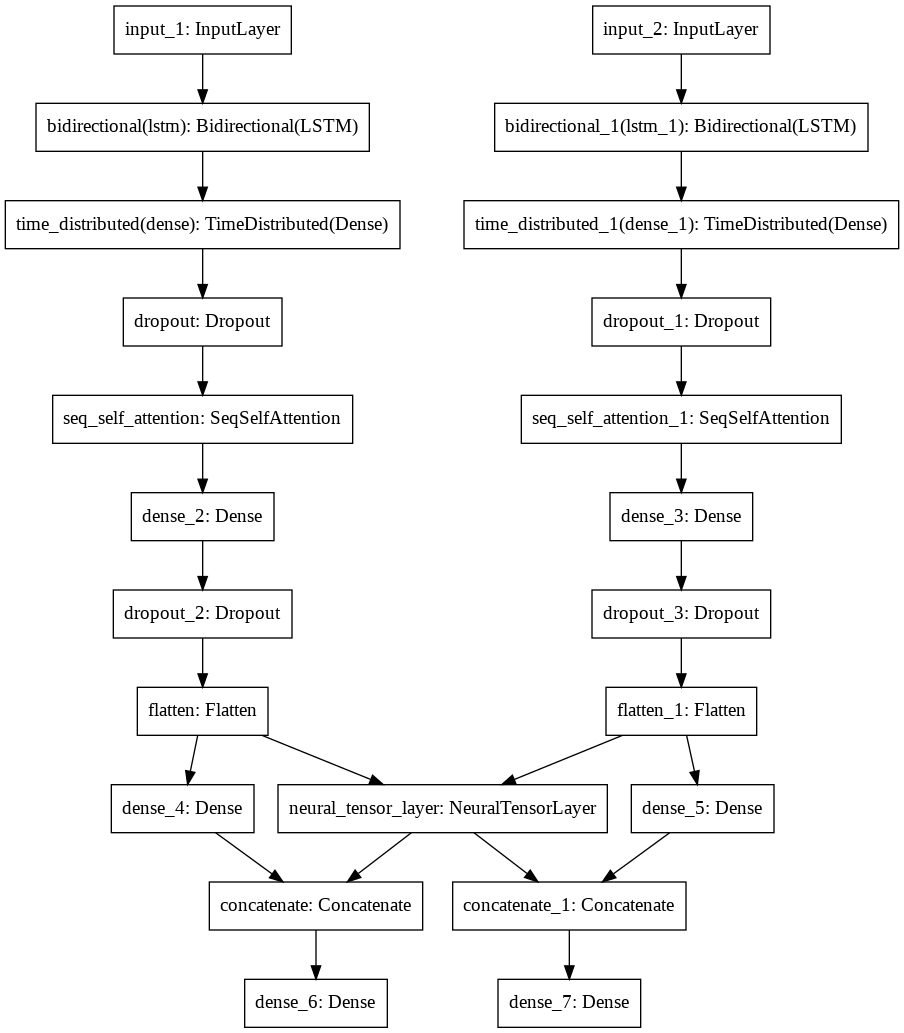

In [20]:
from keras.utils import plot_model
plot_model(model)#, to_file='/content/gdrive/My Drive/Multi_Task_Learning/PangLee/model2.png')

In [22]:
history=model.fit([senti_train, sub_train], [sentlabel_train,sublabel_train], batch_size= 64, epochs=20, verbose=1, shuffle=True,validation_split=0.2)

Epoch 1/20
100/100 [==============================] - 48s 475ms/step - loss: 1.7816 - dense_6_loss: 0.8912 - dense_7_loss: 0.8562 - dense_6_acc: 0.5109 - dense_7_acc: 0.5458 - val_loss: 1.3493 - val_dense_6_loss: 0.7985 - val_dense_7_loss: 0.5168 - val_dense_6_acc: 0.5025 - val_dense_7_acc: 0.7713
Epoch 2/20
100/100 [==============================] - 45s 454ms/step - loss: 1.2263 - dense_6_loss: 0.8259 - dense_7_loss: 0.3669 - dense_6_acc: 0.5316 - dense_7_acc: 0.8494 - val_loss: 1.0337 - val_dense_6_loss: 0.7205 - val_dense_7_loss: 0.2798 - val_dense_6_acc: 0.5688 - val_dense_7_acc: 0.9062
Epoch 3/20
100/100 [==============================] - 45s 455ms/step - loss: 1.0924 - dense_6_loss: 0.7816 - dense_7_loss: 0.2778 - dense_6_acc: 0.5448 - dense_7_acc: 0.8984 - val_loss: 0.8796 - val_dense_6_loss: 0.6102 - val_dense_7_loss: 0.2368 - val_dense_6_acc: 0.6637 - val_dense_7_acc: 0.9119
Epoch 4/20
100/100 [==============================] - 45s 455ms/step - loss: 0.7510 - dense_6_loss: 0.4

KeyboardInterrupt: ignored

In [ ]:
score = model.evaluate([senti_test, sub_test], [sentlabel_test,sublabel_test], verbose=1)
score

2000/2000 [==============================] - 14s 7ms/step


[0.3039615527689457,
 0.162520632147789,
 0.13906776905059814,
 0.9459999799728394,
 0.9514999985694885]

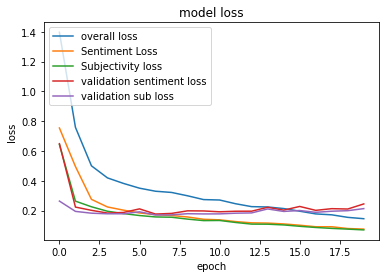

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['dense_6_loss'])
plt.plot(history.history['dense_7_loss'])
plt.plot(history.history['val_dense_6_loss'])
plt.plot(history.history['val_dense_7_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['overall loss','Sentiment Loss', 'Subjectivity loss','validation sentiment loss', 'validation sub loss'], loc='upper left')

# plt.savefig("/content/gdrive/My Drive/Multi_Task_Learning/results/Loss_best.png")
plt.show()

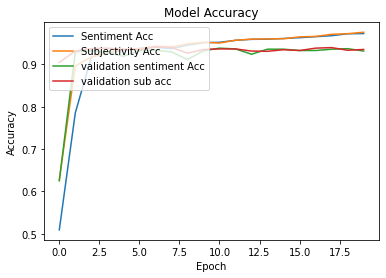

In [ ]:
plt.plot(history.history['dense_6_acc'])
plt.plot(history.history['dense_7_acc'])
plt.plot(history.history['val_dense_6_acc'])
plt.plot(history.history['val_dense_7_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sentiment Acc', 'Subjectivity Acc','validation sentiment Acc', 'validation sub acc'], loc='upper left')

# plt.savefig("/content/gdrive/My Drive/Multi_Task_Learning/results/Acc_best.png")
plt.show()

In [ ]:
# model_json = model.to_json()
# with open("/content/gdrive/My Drive/Multi_Task_Learning/PangLee/model/model_bert.json", "w") as json_file:
#     json_file.write(model_json)

In [ ]:
# model.save_weights("/content/gdrive/My Drive/Multi_Task_Learning/PangLee/model/model_bert.h5")

RuntimeError: ignored

In [ ]:
###Multi task Model
deep_inputs_1 = Input(shape=(45,768))
deep_inputs_2 = Input(shape=(45,768))

model_1_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_1 ) #task 1
model_2_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_2) #task 2

model_1_dense= TimeDistributed(Dense(128,activation='relu',trainable=True))(model_1_LSTM)
model_2_dense=TimeDistributed(Dense(128,activation='relu',trainable=True))(model_2_LSTM)

model_1_dense = Dropout(0.5)(model_1_dense)
model_2_dense = Dropout(0.5)(model_2_dense)

attention_layer_1 = SeqSelfAttention(attention_activation='sigmoid')(model_1_dense)
attention_layer_2 = SeqSelfAttention(attention_activation='sigmoid')(model_2_dense)
# attention_layer=attention()(model_1_dense)

model_12_dense =Dense(10,activation='relu',trainable=True)(attention_layer_1)
model_22_dense =Dense(10,activation='relu',trainable=True)(attention_layer_2)

drop_3 = Dropout(0.5)(model_12_dense)
drop_4 = Dropout(0.5)(model_22_dense)

# flat_1 = Flatten()(model_12_dense)
# flat_2 = Flatten()(model_22_dense)
flat_1 = Flatten()(drop_3)
flat_2 = Flatten()(drop_4)

# ntn_output = NeuralTensorLayer(output_dim=64, input_dim=450)([flat_1,flat_2])

# merged_1 = Concatenate(axis=1)([flat_1, ntn_output])
# merged_2=Concatenate(axis=1)([flat_2, ntn_output])

predictions1 = Dense(2, activation='softmax')(flat_1 ) #change the output number according to the dataset
predictions2 = Dense(2, activation='softmax')(flat_2)

model_in = Model(inputs=[deep_inputs_1, deep_inputs_2], outputs=[predictions1, predictions2])

opt = Adam(learning_rate=0.0002)
# opt =SGD(learning_rate=0.002)
model_in.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

model_in.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 45, 768)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 45, 768)      0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 45, 256)      918528      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 45, 256)      918528      input_4[0][0]                    
____________________________________________________________________________________________

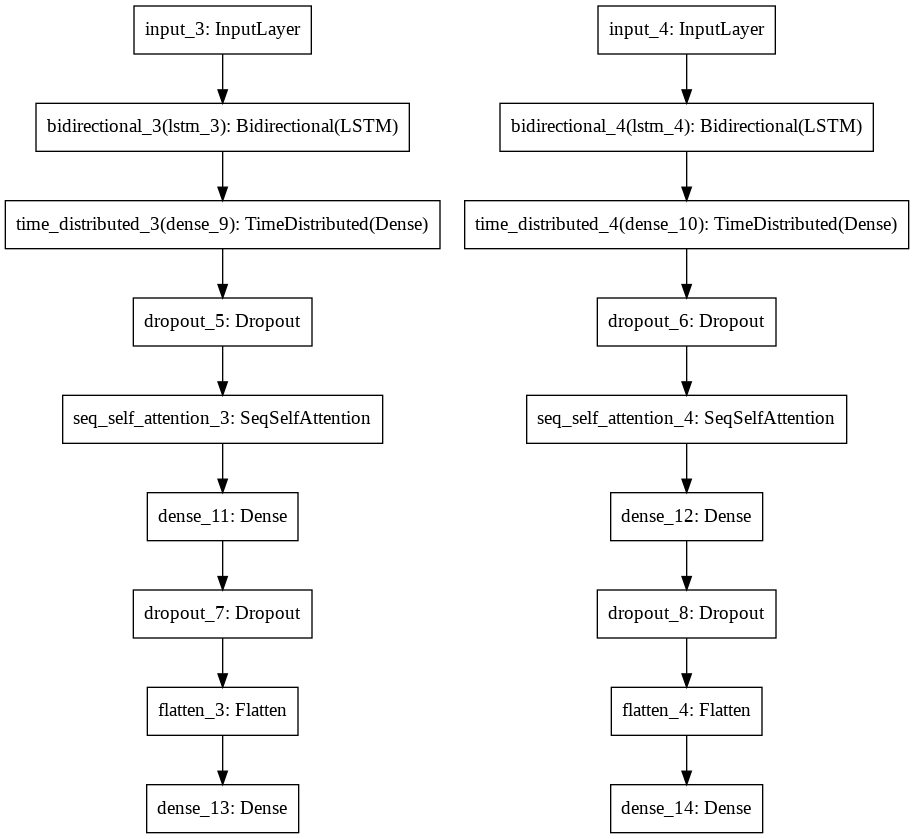

In [ ]:
from keras.utils import plot_model
plot_model(model_in)#, to_file='/content/gdrive/My Drive/Multi_Task_Learning/PangLee/model2.png')

In [ ]:
history=model_in.fit([senti_train, sub_train], [sentlabel_train,sublabel_train], batch_size= 64, epochs=20, verbose=1, shuffle=True,validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 103s 16ms/step - loss: 0.9553 - dense_13_loss: 0.6408 - dense_14_loss: 0.3145 - dense_13_acc: 0.6195 - dense_14_acc: 0.8773 - val_loss: 0.7490 - val_dense_13_loss: 0.5596 - val_dense_14_loss: 0.1894 - val_dense_13_acc: 0.7644 - val_dense_14_acc: 0.9287
Epoch 2/20
6400/6400 [==============================] - 100s 16ms/step - loss: 0.7105 - dense_13_loss: 0.5103 - dense_14_loss: 0.2002 - dense_13_acc: 0.7559 - dense_14_acc: 0.9244 - val_loss: 0.6523 - val_dense_13_loss: 0.4667 - val_dense_14_loss: 0.1856 - val_dense_13_acc: 0.7750 - val_dense_14_acc: 0.9275
Epoch 3/20
6400/6400 [==============================] - 99s 16ms/step - loss: 0.6476 - dense_13_loss: 0.4675 - dense_14_loss: 0.1800 - dense_13_acc: 0.7816 - dense_14_acc: 0.9328 - val_loss: 0.6303 - val_dense_13_loss: 0.4525 - val_dense_14_loss: 0.1778 - val_dense_13_acc: 0.7781 - val_dense_14_acc: 0.9388
Epoch 4/20
6400/6400 [====

In [ ]:
score = model_in.evaluate([senti_test, sub_test], [sentlabel_test,sublabel_test], verbose=1)
score

2000/2000 [==============================] - 12s 6ms/step


[0.6400586071014405,
 0.4652484059333801,
 0.17343980073928833,
 0.7749999761581421,
 0.9350000023841858]

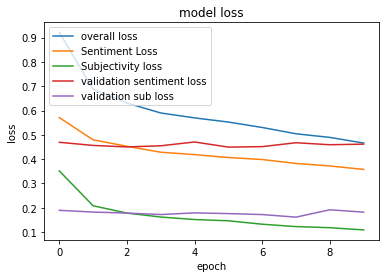

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['dense_29_loss'])
plt.plot(history.history['dense_30_loss'])
plt.plot(history.history['val_dense_29_loss'])
plt.plot(history.history['val_dense_30_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['overall loss','Sentiment Loss', 'Subjectivity loss','validation sentiment loss', 'validation sub loss'], loc='upper left')

# plt.savefig("/content/gdrive/My Drive/Multi_Task_Learning/results/Loss_best.png")
plt.show()

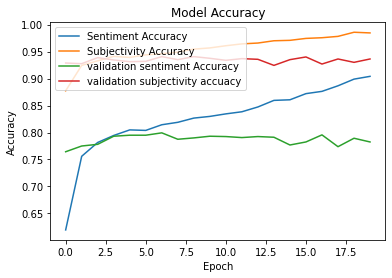

In [ ]:
plt.plot(history.history['dense_13_acc'])
plt.plot(history.history['dense_14_acc'])
plt.plot(history.history['val_dense_13_acc'])
plt.plot(history.history['val_dense_14_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sentiment Accuracy', 'Subjectivity Accuracy','validation sentiment Accuracy', 'validation subjectivity accuacy'], loc='upper left')

plt.savefig("/content/gdrive/My Drive/Multi_Task_Learning/PangLee/Graphs/Acc_bert_withoutntn.png")
plt.show()

In [ ]:
# model_json = model_in.to_json()
# with open("/content/gdrive/My Drive/Multi_Task_Learning/PangLee/model/model_individual.json", "w") as json_file:
#     json_file.write(model_json)

In [ ]:
# model.save_weights("/content/gdrive/My Drive/Multi_Task_Learning/PangLee/model/model_individual.h5")